In [18]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [19]:
from fastai.imports import *

In [20]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

This is the PATH to our data. **Sz** is the size that the image will be resized to, to ensure that the training runs quickly.

In [21]:
PATH = "data/dogscats/"
sz = 224

In [22]:
sz=224

In [23]:
import torch
torch.cuda.is_available()

True

In [24]:
torch.backends.cudnn.enabled

True

In [27]:
!ls {PATH}

models	sample	test1  tmp  train  valid


In [28]:
!ls {PATH}valid

cats  dogs


In [29]:
files = !ls {PATH}valid/cats | head
files

['cat.1001.jpg',
 'cat.10016.jpg',
 'cat.10026.jpg',
 'cat.10048.jpg',
 'cat.10050.jpg',
 'cat.10064.jpg',
 'cat.10071.jpg',
 'cat.10091.jpg',
 'cat.10103.jpg',
 'cat.10104.jpg']

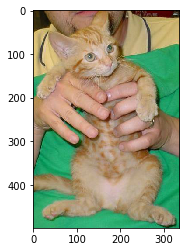

In [30]:
img = plt.imread(f'{PATH}valid/cats/{files[0]}')
plt.imshow(img);

In [31]:
img.shape

(499, 336, 3)

In [32]:
img[:4,:4]

array([[[60, 58, 10],
        [60, 57, 14],
        [61, 56, 18],
        [63, 54, 23]],

       [[56, 54,  6],
        [56, 53, 10],
        [57, 52, 14],
        [60, 51, 20]],

       [[52, 49,  4],
        [52, 49,  6],
        [53, 48, 10],
        [56, 47, 16]],

       [[50, 47,  2],
        [50, 47,  4],
        [51, 45,  9],
        [53, 44, 13]]], dtype=uint8)

We are going to use a pre-trained model. This model is trained on Imagenet. This model is Convolutional Neural Network (CNN), a type of neural network that builds state-of-the-art models for computer vision.
It is the **resnet34** model.

In [33]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch,data,precompute=True)
learn.fit(0.01,3)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.042416   0.027109   0.990723  
    1      0.040854   0.02848    0.991211                     
    2      0.030756   0.023542   0.992188                     



[0.023541618, 0.9921875]

In [34]:
data.val_y

array([0, 0, 0, ..., 1, 1, 1])

In [35]:
data.classes

['cats', 'dogs']

In [36]:
log_preds = learn.predict()
log_preds.shape

(2000, 2)

In [37]:
log_preds[:10]

array([[ -0.00002, -10.97362],
       [ -0.00266,  -5.92904],
       [ -0.00003, -10.53206],
       [ -0.00192,  -6.25781],
       [ -0.00001, -11.22985],
       [ -0.00034,  -7.98924],
       [ -0.00001, -11.8293 ],
       [ -0.00011,  -9.13055],
       [ -0.00011,  -9.14445],
       [ -0.00002, -10.97772]], dtype=float32)

In [38]:
preds = np.argmax(log_preds,axis=1)
probs = np.exp(log_preds[:,1])

In [52]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0],4,replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds==data.val_y)==is_correct)

In [53]:
def plot_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print (title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [54]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [55]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

Correctly Classified


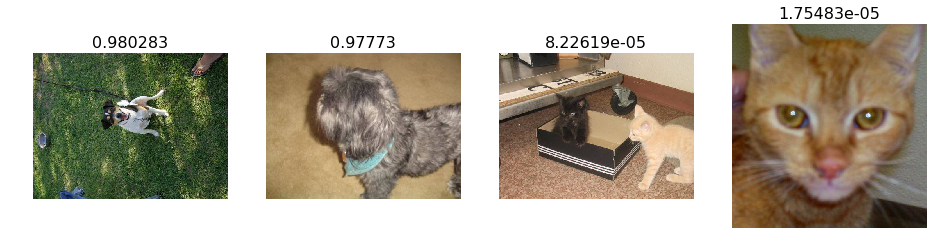

In [56]:
plot_val_with_title(rand_by_correct(True), "Correctly Classified")

Incorrectly Classified


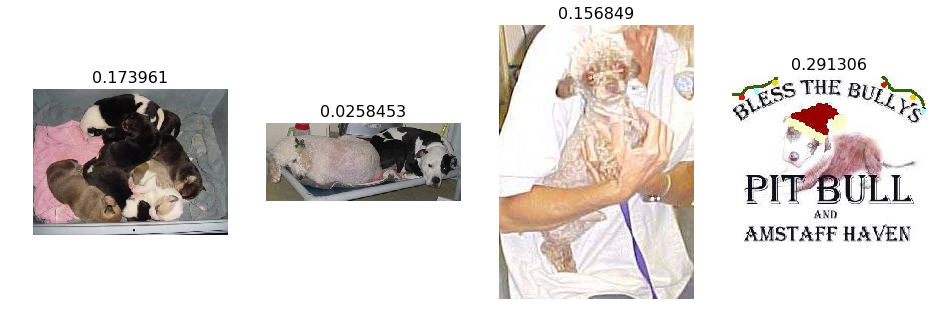

In [57]:
plot_val_with_title(rand_by_correct(False), "Incorrectly Classified")

In [58]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult*probs[idxs])[:4]]

def most_by_correct(y, is_correct):
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


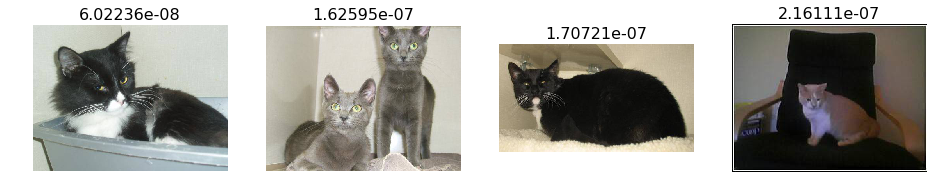

In [59]:
plot_val_with_title(most_by_correct(0, True), "Most correct cats")

Most correct dogs


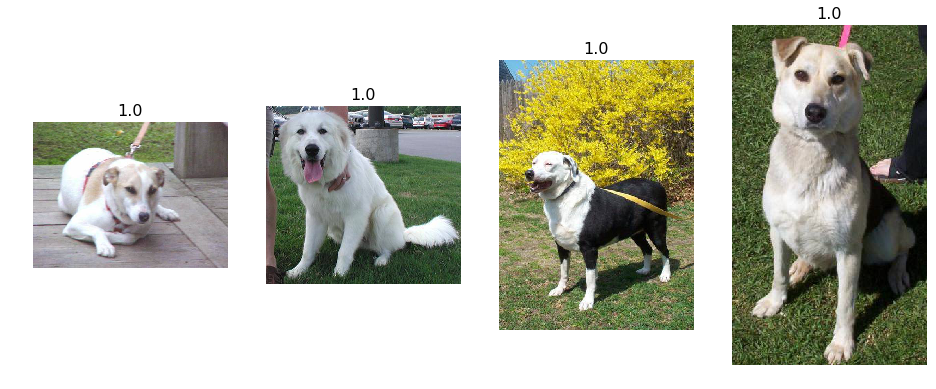

In [60]:
plot_val_with_title(most_by_correct(1, True), "Most correct dogs")

Most incorrect cats


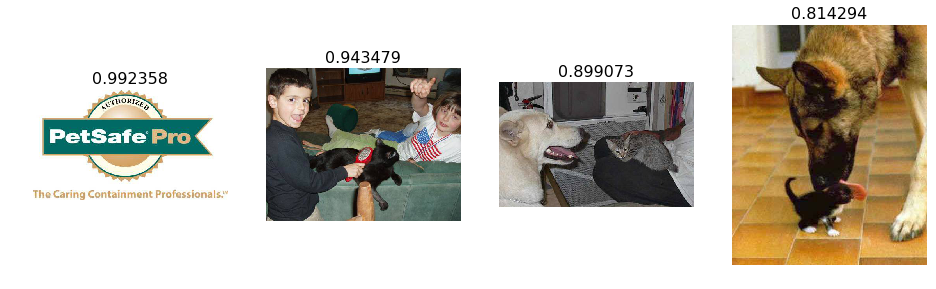

In [61]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


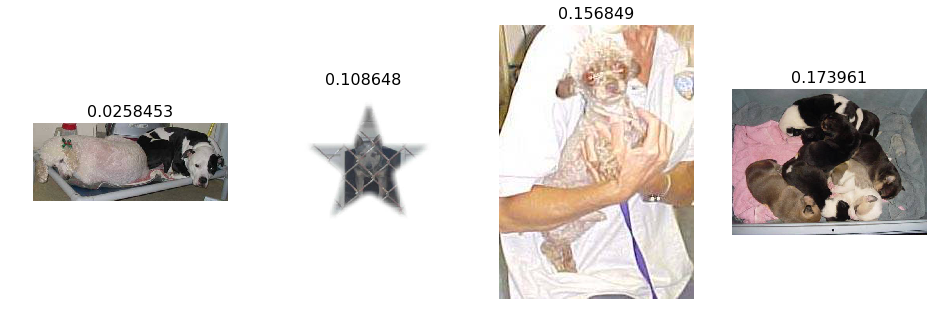

In [62]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

Most uncertain predictions


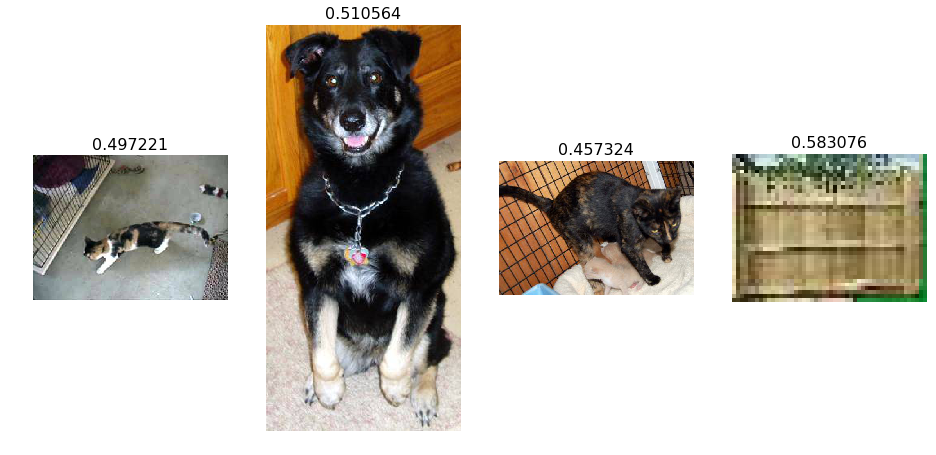

In [63]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

In [64]:
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [67]:
lrf=learn.lr_find()

A Jupyter Widget

 84%|████████▎ | 301/360 [00:05<00:01, 51.82it/s, loss=0.4]   


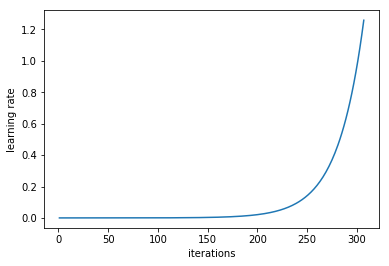

In [68]:
learn.sched.plot_lr()

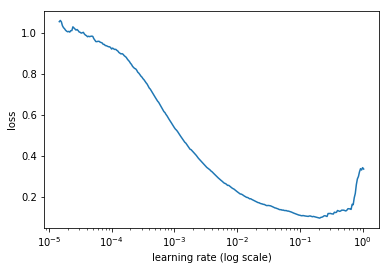

In [69]:
learn.sched.plot()

In [70]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [71]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [73]:
ims = np.stack([get_augs() for i in range(6)])

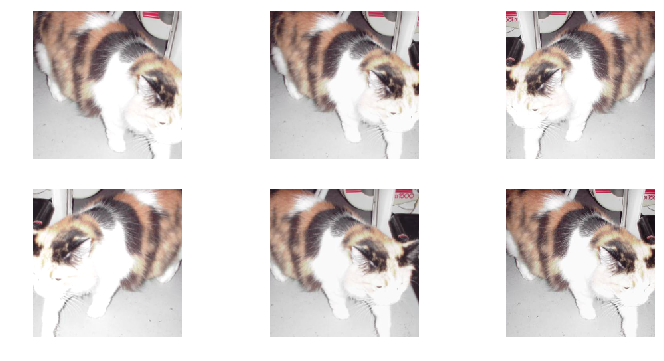

In [74]:
plots(ims, rows=2)

In [75]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)

In [76]:
learn.fit(1e-2, 1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.049269   0.026991   0.989746  



[0.026990835, 0.98974609375]

In [77]:
learn.precompute=False

In [78]:
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.057134   0.02659    0.987305  
    1      0.049969   0.024968   0.989746                     
    2      0.042749   0.024526   0.990234                     



[0.024525698, 0.990234375]

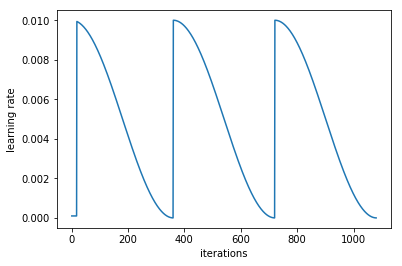

In [79]:
learn.sched.plot_lr()

In [80]:
learn.save('224_lastlayer')

In [81]:
learn.unfreeze()

In [82]:
lr=np.array([1e-4,1e-3,1e-2])

In [83]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.05326    0.027842   0.987793  
    1      0.030799   0.021281   0.988281                     
    2      0.033614   0.020649   0.990234                     
    3      0.029312   0.017337   0.995117                     
    4      0.028975   0.01622    0.995605                     
    5      0.01871    0.016967   0.996094                     
    6      0.019796   0.017026   0.994629                     



[0.017025633, 0.99462890625]

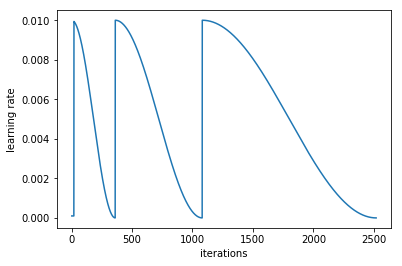

In [84]:
learn.sched.plot_lr()

In [85]:
learn.save('224_all')

In [86]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [87]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [88]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[995   5]
 [  7 993]]


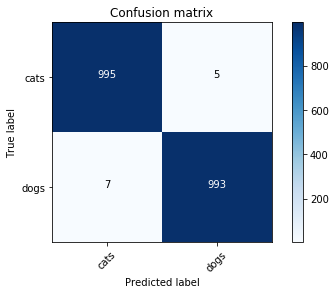

In [89]:
plot_confusion_matrix(cm, data.classes)

Most incorrect cats


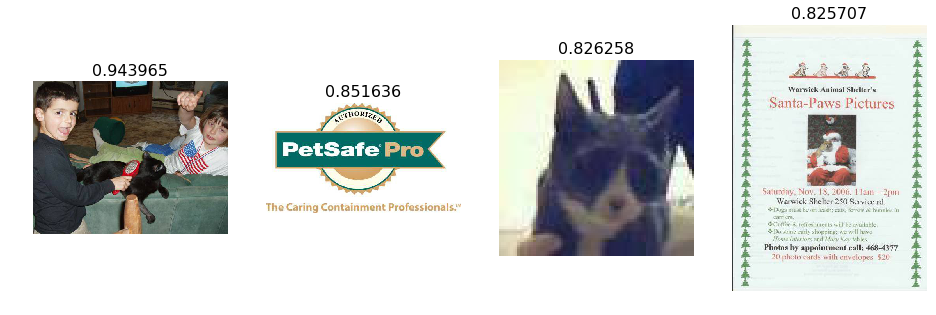

In [90]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

Most incorrect dogs


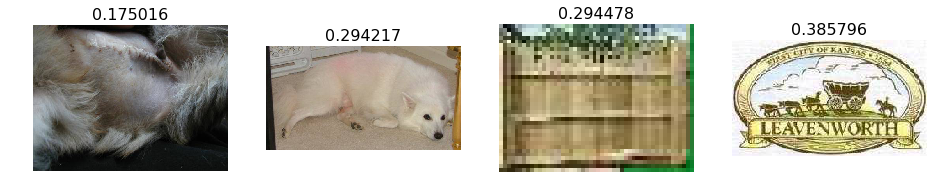

In [91]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [92]:
tfms = tfms_from_model(resnet34, sz)

In [93]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms)

In [94]:
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

In [95]:
learn.fit(1e-2, 1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.043129   0.027022   0.992188  



[0.027021512, 0.9921875]

In [96]:
def binary_loss(y, p):
    return np.mean(-(y * np.log(p) + (1-y)*np.log(1-p)))

In [97]:
acts = np.array([1, 0, 0, 1])
preds = np.array([0.9, 0.1, 0.2, 0.8])
binary_loss(acts, preds)

0.164252033486018